In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import sys
#sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
#sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile/brenier/")
sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import argparse
import numpy as np
import scipy

#our libs
import matplotlib.pyplot as plt
import seaborn as sns
#import utils
#from utils import truncated_normal
#from gen_data import *
#from torchvision import datasets, transforms, utils
from brenier.models import ConditionalConvexQuantile,dual_JK

In [4]:
from config import parse_args
args = parse_args("",None)   
HPARAM = {"nu":args.nu, "sigma0_sq":args.sigma0_sq, 
          "mu0":args.mu0,"kappa":args.kappa}

In [5]:
from _utils.toy_2d_util import test
from _utils.breiner_util import plot2d, histogram, plotaxis
from _data.gaussian_conjugate import forward_sampler, posterior_sampler, gauss_gen

In [6]:
class args:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gauss=False#True #False
    batch_size = 128 
    epoch = 150 
    n_iter= 100
    
    optimizer='adam'
    lr=0.01#05
    beta1 = 0.9 
    beta2=0.999
    nesterov=False
    iters=1000
    mean=0
    std=1    


    eps=0
    
    n_sample = 2

In [7]:
print("Input arguments:")
for key, val in vars(args).items():
    print("{:16} {}".format(key, val))

Input arguments:
__module__       __main__
device           cuda
gauss            False
batch_size       128
epoch            150
n_iter           100
optimizer        adam
lr               0.01
beta1            0.9
beta2            0.999
nesterov         False
iters            1000
mean             0
std              1
eps              0
n_sample         2
__dict__         <attribute '__dict__' of 'args' objects>
__weakref__      <attribute '__weakref__' of 'args' objects>
__doc__          None


In [8]:
#HPARAM = {"nu":1, "sigma0_sq":1, "mu0":0,"kappa":2}
#HPARAM = {"nu":25, "sigma0_sq":1, "mu0":0,"kappa":2}
#ds = Synthetic(args, n=args.n)
#loader = data.DataLoader(ds, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [16]:
import pickle
M = 0.1
path = F"./data/tabc_M{M}.dat"

with open(path, 'rb') as file:
    tabc = pickle.load(file)
    

In [25]:
net = ConditionalConvexQuantile(xdim=args.n_sample,
                                ydim=2, 
                                a_hid=512,
                                a_layers=3,
                                b_hid=512,
                                b_layers=3)

net.to(args.device)
0

0

In [26]:
def unif(size, eps=1E-7, device ="cuda"):
    return torch.clamp(torch.rand(size).to(device), min=eps, max=1-eps)

np_random = np.random.RandomState(1234)

def train(net, HPARAM, args):

    #eg = Rings() # EightGaussian()
    gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                              torch.tensor([1.]).to(args.device))
    for epoch in range(1, args.epoch+1):
        net.train()
        optimizer = optim.Adam(net.parameters(), lr=args.lr*(0.99**2), betas=(args.beta1, args.beta2))
        running_loss = 0.0
        for idx in range(args.n_iter):
            #print(idx)
            
            parameters = tabc.massive_sample(eps=1, 
                                             batch_size=args.batch_size, 
                                             n_proposal=5000)
            x = gauss_gen(parameters, 
                      as_torch=True,
                      np_random =np_random,
                      n = 2, batch_size=args.batch_size, 
                      device=args.device)
            Y, label = torch.from_numpy(parameters).to(args.device).float(),x
            '''
            Y, label = forward_sampler(n = args.n_sample, 
                                batch_size=args.batch_size,
                                device=args.device,
                                h_param=HPARAM,
                                as_torch = True,
                                np_random = np_random)
            '''
            u = unif(size=(args.batch_size, args.n_sample), 
                     device=args.device)
            if args.gauss:
                u = gauss.icdf(u)
            optimizer.zero_grad()
            X,_ = net.f(label.unsqueeze(1))
            alpha, beta= net(u)
            loss = dual_JK(U=u, Y_hat=(alpha, beta), Y=Y, X=X, eps=args.eps, efficient=True)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 5 == 0:
            print('%.5f' %
                (running_loss))#/(idx+1)))
            #test(net, args,False, HPARAM,test_val=M)
            test({"net": net}, 2,False, HPARAM,show=True,test_val=M)
            print(Y.shape)
            
            

76.27457


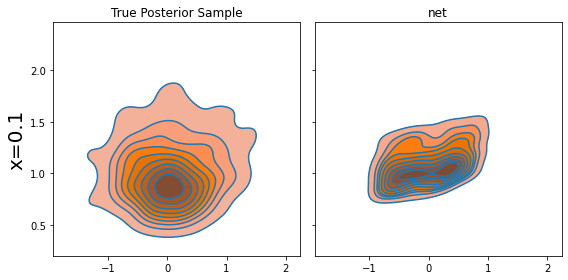

75.05669


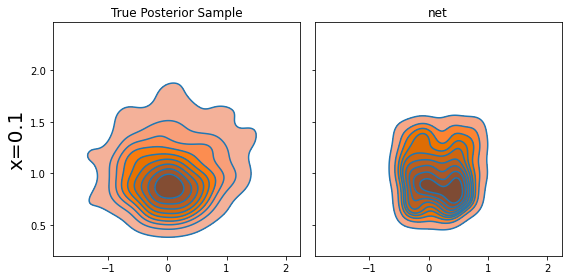

76.75182


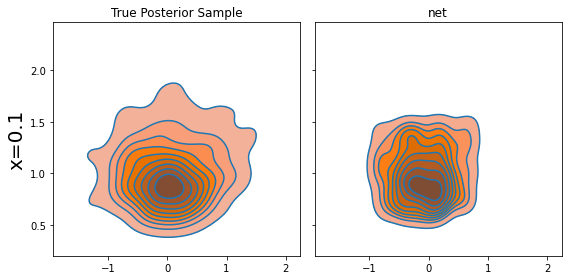

75.52242


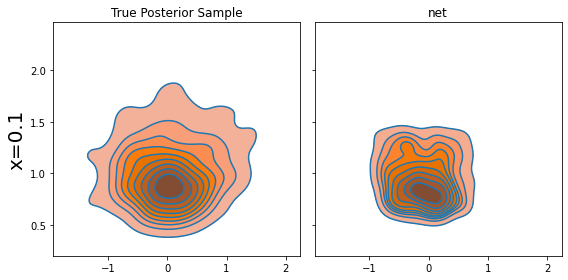

74.53810


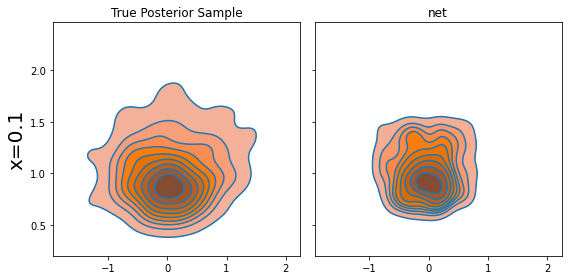

76.19585


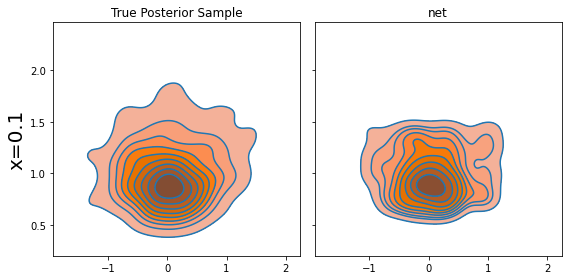

74.55229


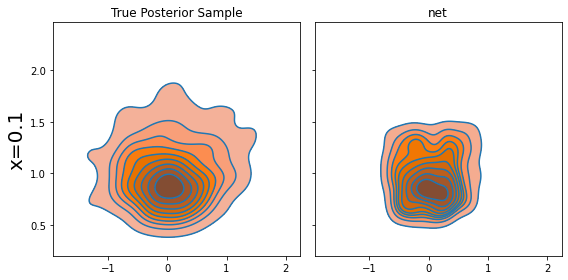

75.19995


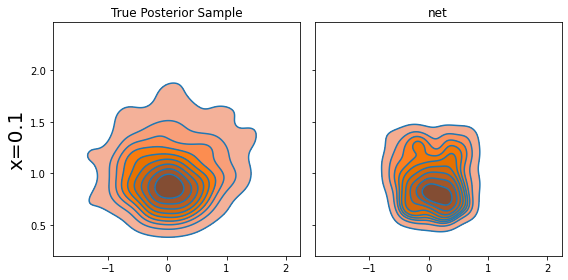

75.33145


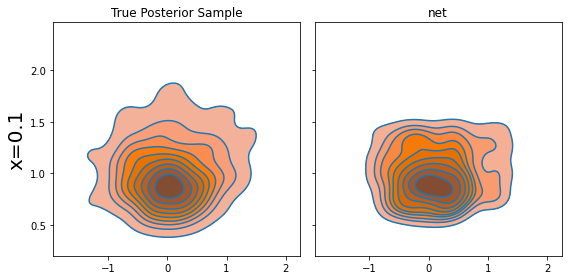

75.47030


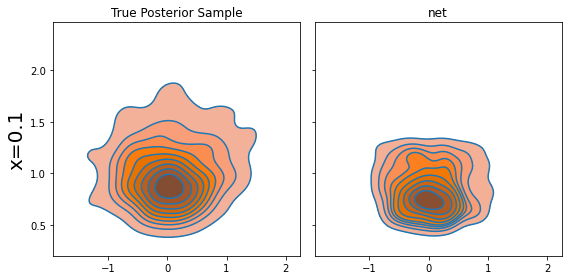

74.11033


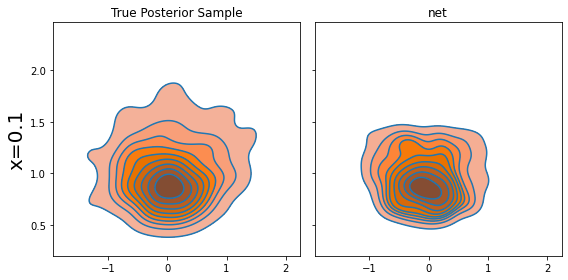

75.68371


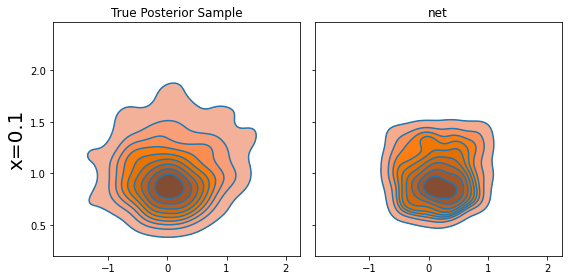

74.82644


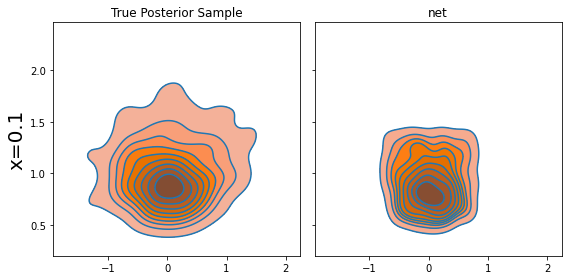

78.03749


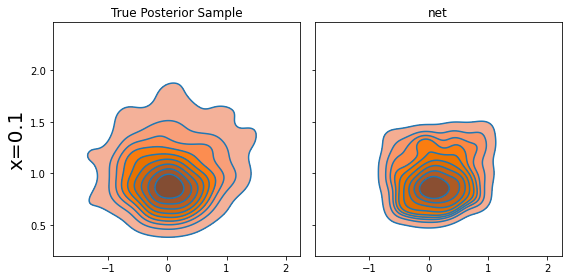

76.65129


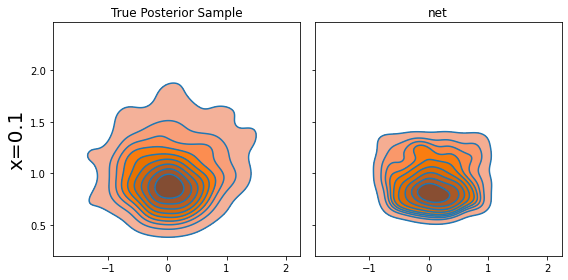

75.22578


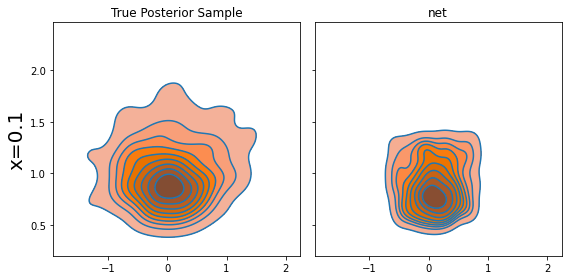

75.37163


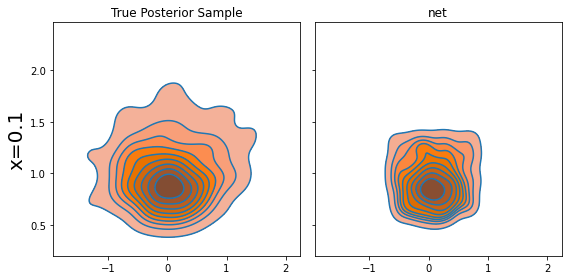

74.06276


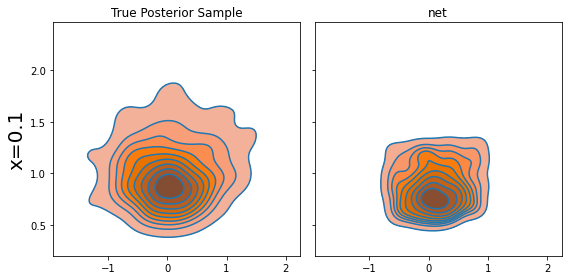

In [ ]:
train(net, HPARAM, args)

118.22296


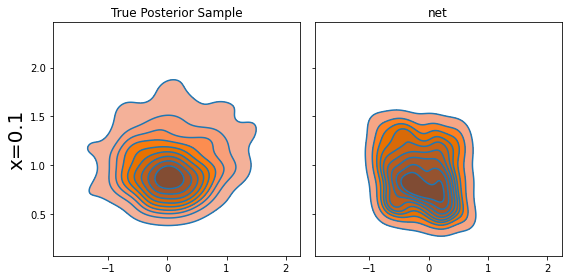

83.45230


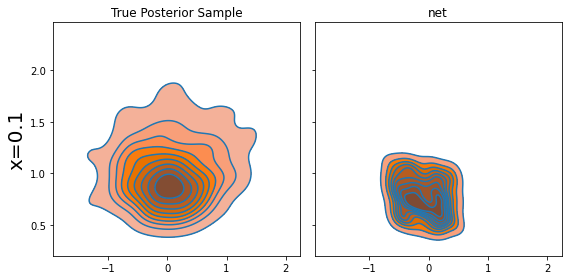

77.13262


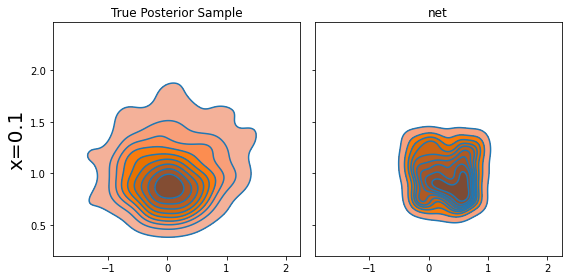

KeyboardInterrupt: 

In [82]:
_#eg = Rings() # EightGaussian()
gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                          torch.tensor([1.]).to(args.device))
for epoch in range(1, args.epoch+1):
    #print(epoch)
    optimizer = optim.Adam(net.parameters(), lr=args.lr*(0.99**2), betas=(args.beta1, args.beta2))
    running_loss = 0.0
    for idx in range(args.n_iter):
        #print(idx)
        parameters, _ = tabc.massive_sample(batch_size=args.batch_size, 
                                            n_proposal=5000)
        x = gauss_gen(parameters, 
                  as_torch=True,
                  np_random =np_random,
                  n = 2, batch_size=args.batch_size, 
                  device=args.device)
        Y, label = torch.from_numpy(parameters).to(args.device).float(),x
        u = unif(size=(args.batch_size, args.n_sample), 
                 device=args.device)
        if args.gauss:
            u = gauss.icdf(u)
        optimizer.zero_grad()
        X,_ = net.f(label.unsqueeze(1))
        alpha, beta= net(u)
        loss = dual_JK(U=u, Y_hat=(alpha, beta), Y=Y, X=X, eps=args.eps, efficient=True)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 1 == 0:
        print('%.5f' %
            (running_loss))#/(idx+1)))
        #test(net, args,False, HPARAM,test_val=M)
        test({"net": net}, args.n_sample,False, HPARAM,test_val=M)
        net.train()

TypeError: unif() missing 1 required positional argument: 'generator'

In [80]:



def unif(size,generator,  eps=1E-7, device ="cuda"):
    return torch.clamp(torch.rand(size, generator=generator).to(device), min=eps, max=1-eps)


def test(nets, n_sample, gauss, HPARAM, test_val=2.2, n_test = 500, 
         save_dir=None, show=False, close=True, seed = 1234, device="cuda", fig=None, axis=None):
    generator = torch.Generator()
    generator.manual_seed(seed)
    
    x_test = torch.tensor([test_val for _ in range(n_sample)])
    theta, sigma_sq = posterior_sampler(X = x_test,batch_size=n_test, seed=seed, h_param = HPARAM)
    
    
    U = unif(size=(n_test, 2), generator=generator, device = device)
    
    if gauss:
        gauss = torch.distributions.normal.Normal(
                                            torch.tensor([0.]).to(device), 
                                            torch.tensor([1.]).to(device))
        U = gauss.icdf(U)
        
    X = torch.ones((n_test,n_sample),
                          device=device)*test_val
    
    n_col = 1+len(nets)

    if fig is None: 
        fig,axis = plt.subplots(1,n_col, figsize=(4*n_col,4), sharex=True, sharey=True)

    ax=axis[0]
    ax.set_ylabel(F"x={test_val}", fontsize=20)
    sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) 
    sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) 
    ax.set_title("True Posterior Sample")
    
    for i, (name,net) in enumerate(nets.items()):
        
        ax=axis[i+1]
        net.eval()
        #set_trace()
        Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)
        Y_hat = Y_hat.detach().cpu()
    
        sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) 
        sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) 
        
        ax.set_title(name)
        
    fig.tight_layout()
    if save_dir is not None:
        fig.savefig(save_dir)
    if show:
        plt.show()
    if close:
        plt.close()



In [81]:
test({"net": net}, 2,False, HPARAM,test_val=M)

In [68]:
nets = {"net": net}
seed=10
n_sample=100
test_val=10
n_test=20
generator = torch.Generator()
generator.manual_seed(seed)

U = unif(size=(128, 2), device = args.device)
x_test = torch.tensor([test_val for _ in range(n_sample)])
net.eval()
Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)
Y_hat = Y_hat.detach().cpu()

In [66]:
U.shape, X.shape

(torch.Size([20, 2]), torch.Size([128, 2]))

RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 500

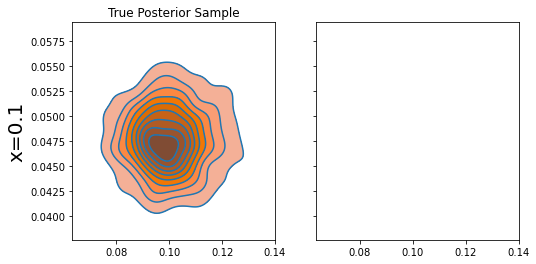

In [35]:
test({"net": net}, 500,False, HPARAM,test_val=M)

In [22]:
torch.tensor([0.1 for _ in range(10)])

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [16]:
n_test = 500
KK=1.2
theta, sigma_sq = posterior_sampler(X = torch.tensor([KK,KK]), 
                                                batch_size=args.batch_size,
                                                as_torch =False,
                                                seed=12334)
net.eval()
gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                          torch.tensor([1.]).to(args.device))
U = unif(size=(n_test, 2), device = args.device)
if args.gauss:
    U = gauss.icdf(U)
X = torch.ones((n_test,args.n_sample),
                      device=args.device)*KK #.long()
#print(X)
Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)#= net.forward(U, grad=True).sum()
#Y_hat = net.grad(U)
print("max and min points generated: " + str(Y_hat.max()) + " " + str(Y_hat.min()))
#plot(Y_hat, X ,HPARAM)
Y_hat = Y_hat.detach().cpu()

max and min points generated: tensor(1.6727, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.1270, device='cuda:0', grad_fn=<MinBackward1>)


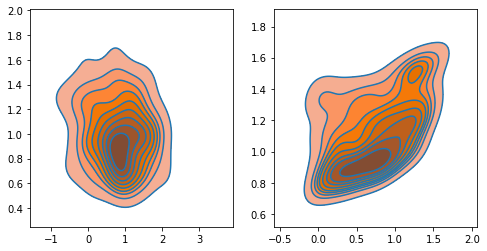

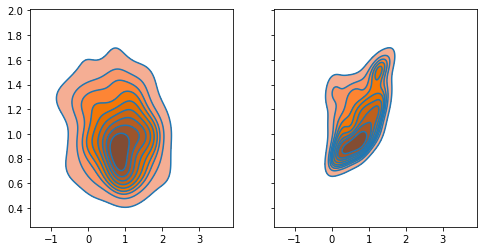

In [17]:
import seaborn as sns

fig,axis = plt.subplots(1,2, figsize=(8,4))#, sharex=True, sharey=True)

ax=axis[0]
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) #, cmap="Blues"

ax=axis[1]
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) #, cmap="Blues"

plt.show()

import seaborn as sns

fig,axis = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

ax=axis[0]
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) #, cmap="Blues"

ax=axis[1]
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) #, cmap="Blues"

plt.show()

In [19]:
import pathlib
path = "./trained_nets"
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
torch.save(net.state_dict(),  path+F"/uniform_seed_all_x.net")

In [32]:
n_test = 500
theta, sigma_sq = posterior_sampler(X = torch.tensor([2.2,2.2]), 
                                                batch_size=args.batch_size,
                                                as_torch =False,
                                                np_random =np_random )
net.eval()
gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                          torch.tensor([1.]).to(args.device))
U = unif(size=(n_test, 2), device = args.device)
if args.gauss:
    U = gauss.icdf(U)
X = torch.ones((n_test,args.n_sample),
                      device=args.device)*2.2 #.long()
#print(X)
Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)#= net.forward(U, grad=True).sum()
#Y_hat = net.grad(U)
print("max and min points generated: " + str(Y_hat.max()) + " " + str(Y_hat.min()))
#plot(Y_hat, X ,HPARAM)
Y_hat = Y_hat.detach().cpu()

> /home/kim2712/Desktop/research/generative_quantile/generative_qunatile/brenier/models.py(376)grad()
    374         if self.xdim != 0 and x != None:
    375             set_trace()
--> 376             phi += (torch.bmm(self.beta(u).unsqueeze(1), x.unsqueeze(-1)).squeeze(-1)).sum()
    377         d_phi = torch.autograd.grad(phi, u, create_graph=True)[0]
    378         return d_phi, xv

ipdb> print(x.shape)
torch.Size([500, 2])
ipdb> print(x.unsqueeze(-1).shape)
torch.Size([500, 2, 1])
ipdb> self.beta(u).unsqueeze(1).shape
torch.Size([500, 1, 2])
ipdb> exit


BdbQuit: 